In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Load Train and Validation Data

# Load the train data
train_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv"
train_df = pd.read_csv(train_url)

# Load the validation data
val_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Val.csv"
val_df = pd.read_csv(val_url)



In [2]:
# View Train Data
train_df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [3]:
val_df.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


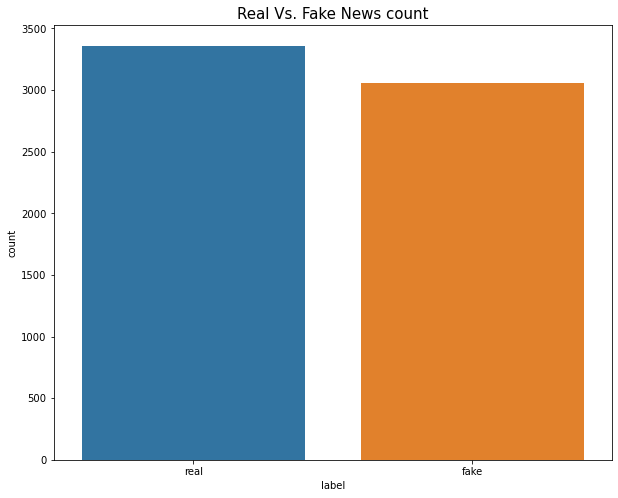

In [4]:
# Evaluate whether the data is balanced or not
plt.figure(figsize = (10,8))
sns.countplot(train_df['label'])
plt.title("Real Vs. Fake News count", fontsize = 15)
plt.show()

In [5]:
# Upsample Fake News to Balance the Dataset
from sklearn.utils import resample

df_majority = train_df[train_df.label =='real']
df_minority = train_df[train_df.label == 'fake']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])
df_upsampled

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
5,6,"Covid Act Now found ""on average each person in...",real
...,...,...,...
3701,3702,"Trudeau airs a coronavirus update rerun, to se...",fake
2486,2487,Trumps nude statue is made in New York city be...,fake
5469,5470,Says Russia unleashed more than 500 lions on i...,fake
1982,1983,Hospital in Pakistan is overwhelmed by COVID-1...,fake


In [6]:
## Validating that dataset is balanced after upsampling
print("Real News Dataset Size: " + str(df_majority.shape))
print("Fake News Dataset Size Before Upsampling: " + str(df_minority.shape))
print("Fake News Dataset Size After Upsampling: " + str(negative_upsample.shape))

Real News Dataset Size: (3360, 3)
Fake News Dataset Size Before Upsampling: (3060, 3)
Fake News Dataset Size After Upsampling: (3360, 3)


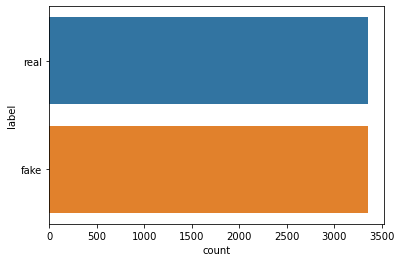

In [7]:
sns.countplot(y="label", data = df_upsampled);

In [8]:
## Check if validation set size
len(val_df)

2140

In [9]:
## Split train and test, drop id column, and binarize target
x_train = df_upsampled
x_val = val_df
y_train = df_upsampled[['label']].to_numpy()
y_val = val_df[['label']].to_numpy()
from sklearn import preprocessing
y_train= preprocessing.label_binarize(y_train, classes =['real', 'fake'])
y_val = preprocessing.label_binarize(y_val, classes=['real', 'fake'])


In [10]:
x_train

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
5,6,"Covid Act Now found ""on average each person in...",real
...,...,...,...
3701,3702,"Trudeau airs a coronavirus update rerun, to se...",fake
2486,2487,Trumps nude statue is made in New York city be...,fake
5469,5470,Says Russia unleashed more than 500 lions on i...,fake
1982,1983,Hospital in Pakistan is overwhelmed by COVID-1...,fake


In [11]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

## Preprocessing Methods

In [12]:
# Download stopwords and its dependencies for preprocessing
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wn = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksnss\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksnss\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ksnss\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
pip install cleantext

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Pre-Processed News Dataset 1
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation
# 5. lemmatize words

from string import punctuation

def lemmatize_preprocessed_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Lemmatize words
    lemmatized_words = [wn.lemmatize(word) for word in words]
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in lemmatized_words)
    
    return cleaned_news_excerpt

In [15]:
# Pre-Processed News Dataset 2
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation
# 5. stem words

def stemmed_preprocessed_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Stem words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in stemmed_words)
    
    return cleaned_news_excerpt

In [16]:
# Pre-Processed News Dataset 3
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation

def preprocess_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in words)
    
    return cleaned_news_excerpt

In [17]:
import nltk
nltk.download('omw-1.4')
x_train["lemmatized_tweet"] = x_train["tweet"].apply(lemmatize_preprocessed_news)
x_train["stemmed_tweet"] = x_train["tweet"].apply(stemmed_preprocessed_news)
x_train["cleaned_tweet"] = x_train["tweet"].apply(preprocess_news)
x_train["lemmatized_tokens"] = x_train["lemmatized_tweet"].str.split(" ")
x_train["stemmed_tokens"] = x_train["stemmed_tweet"].str.split(" ")
x_val["lemmatized_tweet"] = x_val["tweet"].apply(lemmatize_preprocessed_news)
x_val["stemmed_tweet"] = x_val["tweet"].apply(stemmed_preprocessed_news)
x_val["lemmatized_tokens"] = x_val["lemmatized_tweet"].str.split(" ")
x_val["stemmed_tokens"] = x_val["stemmed_tweet"].str.split(" ")
x_train.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ksnss\AppData\Roaming\nltk_data...


,id,tweet,label,lemmatized_tweet,stemmed_tweet,cleaned_tweet,lemmatized_tokens,stemmed_tokens
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently report 99031 death general discr...,cdc current report 99031 death gener discrep d...,cdc currently reports 99031 deaths general dis...,"[cdc, currently, report, 99031, death, general...","[cdc, current, report, 99031, death, gener, di..."
1,2,States reported 1121 deaths a small rise from ...,real,state reported 1121 death small rise last tues...,state report 1121 death small rise last tuesda...,states reported 1121 deaths small rise last tu...,"[state, reported, 1121, death, small, rise, la...","[state, report, 1121, death, small, rise, last..."
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona 1524 covid testing laborator...,indiafightscorona 1524 covid test laboratori i...,indiafightscorona 1524 covid testing laborator...,"[indiafightscorona, 1524, covid, testing, labo...","[indiafightscorona, 1524, covid, test, laborat..."
4,5,Populous states can generate large case counts...,real,populous state generate large case count look ...,popul state gener larg case count look new cas...,populous states generate large case counts loo...,"[populous, state, generate, large, case, count...","[popul, state, gener, larg, case, count, look,..."
5,6,"Covid Act Now found ""on average each person in...",real,covid act found on average person illinois cov...,covid act found on averag person illinoi covid...,covid act found on average person illinois cov...,"[covid, act, found, on, average, person, illin...","[covid, act, found, on, averag, person, illino..."


In [18]:
## Conduct EDA and build wordclouds to see the most frequent words that occur in real vs fake tweets 
## using preprocessed reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(x_train[x_train.label == 'real'].cleaned_tweet))
plt.imshow(wc, interpolation = 'bilinear')

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(x_train[x_train.label == 'fake'].cleaned_tweet))
plt.imshow(wc, interpolation = 'bilinear')

In [19]:
## Create Bag of Words preprocessed datasets
from sklearn.feature_extraction.text import CountVectorizer

corpus1 = x_train['tweet'].values.tolist()
corpus2 = x_train['tweet'].values.tolist()
corpus1_val = x_val['tweet'].values.tolist()
corpus2_val = x_val['tweet'].values.tolist()


# Lemmatized One-hot Encoding
vectorizer = CountVectorizer(binary = True, preprocessor= lemmatize_preprocessed_news)
x_lemmatized_ohe = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_ohe_val = vectorizer.transform(corpus1_val).toarray()


# Stemmed One-hot Encoding
x_stemmed_ohe = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_ohe_val = vectorizer.transform(corpus2_val).toarray()


# Lemmatized Bag of Words
vectorizer = CountVectorizer(preprocessor= lemmatize_preprocessed_news)
x_lemmatized_bow = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_bow_val = vectorizer.transform(corpus1_val).toarray()


# Stemmed Bag of Words
vectorizer = CountVectorizer(preprocessor=stemmed_preprocessed_news)
x_stemmed_bow = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_bow_val = vectorizer.transform(corpus2_val).toarray()



In [20]:
## Create TFIDF preprocessed datasets
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor = lemmatize_preprocessed_news)
x_lemmatized_tfidf = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_tfidf_val = vectorizer.transform(corpus1_val).toarray()

vectorizer = TfidfVectorizer(preprocessor=stemmed_preprocessed_news)
x_stemmed_tfidf = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_tfidf_val = vectorizer.transform(corpus2_val).toarray()


In [21]:
pip install --upgrade gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\__pycache__\\cython.cpython-38.pyc'
Consider using the `--user` option or check the permissions.



In [22]:
def create_w2vec_vectors(model, train, val):
  words = set(model.wv.index_to_key)
  x_train = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in train])
  x_val = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in val])
  

  x_train_avg = []
  for i in x_train:
    if i.size:
      x_train_avg.append(i.mean(axis=0))
    else:
        x_train_avg.append(np.zeros(100, dtype=float))

  x_val_avg = []
  for i in x_val:
    if i.size:
      x_val_avg.append(i.mean(axis=0))
    else:
        x_val_avg.append(np.zeros(100, dtype=float))

  return x_train_avg, x_val_avg


In [23]:
## Create Word2Vec vectors
import itertools
import gensim
from gensim.models import Word2Vec
lemmatized_tokns = list(x_train['lemmatized_tokens'])
lemmatized_token_list = list(itertools.chain(*lemmatized_tokns))

CBOW = gensim.models.Word2Vec([lemmatized_token_list], window =5, min_count=1, workers = 4)
SG = gensim.models.Word2Vec([lemmatized_token_list], window =5, min_count=1, workers = 4, sg=1)

#x_train['lemmatized_tokens'].values

#lemmatized_train_CBOW, lemmatized_val_CBOW, lemmatized_test_CBOW = 
lemmatized_train_CBOW, lemmatized_val_CBOW = create_w2vec_vectors(CBOW, x_train['lemmatized_tokens'].values, x_val['lemmatized_tokens'].values)

lemmatized_train_SG, lemmatized_val_SG = create_w2vec_vectors(SG, x_train["lemmatized_tokens"].values, x_val["lemmatized_tokens"].values)



stemmed_tokens = list(x_train['stemmed_tokens'])
stemmed_token_list = list(itertools.chain(*stemmed_tokens))
CBOW = gensim.models.Word2Vec([stemmed_token_list], window =5, min_count=1, workers = 4)
SG = gensim.models.Word2Vec([stemmed_token_list], window =5, min_count=1, workers = 4, sg=1)

stemmed_train_CBOW, stemmed_val_CBOW = create_w2vec_vectors(CBOW, x_train["stemmed_tokens"].values, x_val["stemmed_tokens"].values)

stemmed_train_SG, stemmed_val_SG = create_w2vec_vectors(SG, x_train["stemmed_tokens"].values, x_val["stemmed_tokens"].values)

ModuleNotFoundError: No module named 'gensim'

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
def plot_confusion_matrix(y_true, y_pred):
  cf_matrix = confusion_matrix(y_true, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  return

In [ ]:
#plot precision recall score
from sklearn.metrics import precision_recall_curve
def plot_precision_recall(y_test, y_score):
  precision, recall, thresholds = precision_recall_curve(y_test, y_score)
  fig, ax = plt.subplots()
  ax.plot(recall, precision, color='purple')
  ax.set_title('Precision-Recall Curve')
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  plt.show()

In [ ]:
## Obtain total number of words present in lemmatized reviews
list_of_words = []
for i in x_train.lemmatized_tweet:
    for j in i:
        list_of_words.append(j)
        
total_words_lemmatized_news = len(list(set(list_of_words)))

In [ ]:
## Obtain total number of words present in stemmed reviews
list_of_words = []
for i in x_train.stemmed_tweet:
    for j in i:
        list_of_words.append(j)
        
total_words_stemmed_news = len(list(set(list_of_words)))

PASSIVE AGGRESSIVE CLASSIFIER

BoW model on a plain classifier

In [24]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

model_PA = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
model_PA.fit(x_lemmatized_bow, y_train)
val_pred_PA_bow = model_PA.predict(x_lemmatized_bow_val)
val_pred_PA_bow

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 1, 1, ..., 1, 0, 0])

In [25]:
from sklearn.metrics import f1_score
y_train_pred_bow_PA=model_PA.predict(x_lemmatized_bow)
f1_score(y_train,y_train_pred_bow_PA)

1.0

In [26]:
f1_score(y_val,val_pred_PA_bow)

0.8963110667996013

In [27]:
accuracy_score(y_train,y_train_pred_bow_PA)

1.0

In [28]:
accuracy_score(y_val,val_pred_PA_bow)

0.902803738317757

In [29]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train,y_train_pred_bow_PA)

1.0

In [30]:
precision_score(y_val,val_pred_PA_bow)

0.9117647058823529

In [31]:
recall_score(y_train,y_train_pred_bow_PA)

1.0

In [32]:
recall_score(y_val,val_pred_PA_bow)

0.8813725490196078

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,y_train_pred_bow_PA)

1.0

In [34]:
roc_auc_score(y_val,val_pred_PA_bow)

0.9018469887955182

BoW grid search Passive Aggressive Classifier

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

param_grid_PA={'C':np.arange(0,1,0.25),'max_iter':np.arange(500,1500,200)}
grid_PA_bow=GridSearchCV(PassiveAggressiveClassifier(),param_grid_PA,n_jobs=-1)
grid_PA_bow.fit(x_lemmatized_bow,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.  , 0.25, 0.5 , 0.75]),
                         'max_iter': array([ 500,  700,  900, 1100, 1300])})

In [36]:
grid_PA_bow.best_params_

{'C': 0.25, 'max_iter': 700}

In [37]:
grid_PA_bow.best_estimator_

PassiveAggressiveClassifier(C=0.25, max_iter=700)

In [38]:
y_train_pred_grid_PA_bow=grid_PA_bow.predict(x_lemmatized_bow)

In [39]:
y_pred_grid_PA_bow=grid_PA_bow.predict(x_lemmatized_bow_val)

In [40]:
f1_score(y_train,y_train_pred_grid_PA_bow)

0.99985121261717

In [41]:
f1_score(y_val,y_pred_grid_PA_bow)

0.8916500994035785

In [42]:
accuracy_score(y_train,y_train_pred_grid_PA_bow)

0.9998511904761904

In [43]:
accuracy_score(y_val,y_pred_grid_PA_bow)

0.8981308411214953

In [44]:
precision_score(y_train,y_train_pred_grid_PA_bow)

0.999702469503124

In [45]:
precision_score(y_val,y_pred_grid_PA_bow)

0.9042338709677419

In [46]:
recall_score(y_train,y_train_pred_grid_PA_bow)

1.0

In [47]:
recall_score(y_val,y_pred_grid_PA_bow)

0.8794117647058823

In [48]:
roc_auc_score(y_train,y_train_pred_grid_PA_bow)

0.9998511904761905

In [49]:
roc_auc_score(y_val,y_pred_grid_PA_bow)

0.8972951680672269

PA Classifer stem

In [50]:


model_PA = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
model_PA.fit(x_stemmed_bow, y_train)
val_pred_PA_bow = model_PA.predict(x_stemmed_bow_val)
val_pred_PA_bow

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 0, 1, ..., 1, 0, 0])

In [51]:
from sklearn.metrics import f1_score
y_train_pred_bow_PA=model_PA.predict(x_stemmed_bow)
f1_score(y_train,y_train_pred_bow_PA)

1.0

In [52]:
f1_score(y_val,val_pred_PA_bow)

0.8925373134328358

In [53]:
accuracy_score(y_train,y_train_pred_bow_PA)

1.0

In [54]:
accuracy_score(y_val,val_pred_PA_bow)

0.8990654205607477

In [55]:

precision_score(y_train,y_train_pred_bow_PA)

1.0

In [56]:
precision_score(y_val,val_pred_PA_bow)

0.906060606060606

In [57]:
recall_score(y_train,y_train_pred_bow_PA)

1.0

In [58]:
recall_score(y_val,val_pred_PA_bow)

0.8794117647058823

In [59]:

roc_auc_score(y_train,y_train_pred_bow_PA)

1.0

In [60]:
roc_auc_score(y_val,val_pred_PA_bow)

0.898188025210084

Stem BoW grid search Passive Aggressive Classifier

In [61]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [62]:


param_grid_PA={'C':np.arange(0,1,0.25),'max_iter':np.arange(500,1500,200)}
grid_PA_bow=GridSearchCV(PassiveAggressiveClassifier(),param_grid_PA,n_jobs=-1)
grid_PA_bow.fit(x_stemmed_bow,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.  , 0.25, 0.5 , 0.75]),
                         'max_iter': array([ 500,  700,  900, 1100, 1300])})

In [63]:
grid_PA_bow.best_params_

{'C': 0.25, 'max_iter': 900}

In [64]:
grid_PA_bow.best_estimator_

PassiveAggressiveClassifier(C=0.25, max_iter=900)

In [65]:
y_train_pred_grid_PA_bow=grid_PA_bow.predict(x_stemmed_bow)

In [66]:
y_pred_grid_PA_bow=grid_PA_bow.predict(x_stemmed_bow_val)

In [67]:
f1_score(y_train,y_train_pred_grid_PA_bow)

0.99985121261717

In [68]:
f1_score(y_val,y_pred_grid_PA_bow)

0.889564336372847

In [69]:
accuracy_score(y_train,y_train_pred_grid_PA_bow)

0.9998511904761904

In [70]:
accuracy_score(y_val,y_pred_grid_PA_bow)

0.8981308411214953

In [71]:
precision_score(y_train,y_train_pred_grid_PA_bow)

0.999702469503124

In [72]:
precision_score(y_val,y_pred_grid_PA_bow)

0.9203354297693921

In [73]:
recall_score(y_train,y_train_pred_grid_PA_bow)

1.0

In [74]:
recall_score(y_val,y_pred_grid_PA_bow)

0.8607843137254902

In [75]:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,y_train_pred_grid_PA_bow)

0.9998511904761905

In [76]:
roc_auc_score(y_val,y_pred_grid_PA_bow)

0.8964635854341738

XGBOOST

In [77]:
import xgboost as xgb
model_XG = xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1,min_child_weight=5)
model_XG.fit(x_lemmatized_bow, y_train)

val_pred_XG_bow = model_XG.predict(x_lemmatized_bow_val)
val_pred_XG_bow

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1, 0, 1, ..., 1, 1, 0])

In [78]:
from sklearn.metrics import f1_score
y_train_pred_bow_XG=model_XG.predict(x_lemmatized_bow)
f1_score(y_train,y_train_pred_bow_XG)

0.8616022099447515

In [79]:
f1_score(y_val,val_pred_XG_bow)

0.8301716350496837

In [80]:
accuracy_score(y_train,y_train_pred_bow_XG)

0.8508928571428571

In [81]:
accuracy_score(y_val,val_pred_XG_bow)

0.8242990654205608

In [82]:

precision_score(y_train,y_train_pred_bow_XG)

0.8038659793814433

In [83]:
precision_score(y_val,val_pred_XG_bow)

0.7696817420435511

In [84]:
recall_score(y_train,y_train_pred_bow_XG)

0.9282738095238096

In [85]:
recall_score(y_val,val_pred_XG_bow)

0.9009803921568628

In [86]:

roc_auc_score(y_train,y_train_pred_bow_XG)

0.8508928571428572

In [87]:
roc_auc_score(y_val,val_pred_XG_bow)

0.8277223389355741

BoW grid search XGBOOST

In [89]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_XG={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.02,0.04,0.06]
        }
grid_XG_bow=RandomizedSearchCV(xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1),param_grid_XG,n_jobs=-1)
grid_XG_bow.fit(x_lemmatized_bow,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=10, n_jobs...
                                           nthread=1, num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           r

In [90]:
grid_XG_bow.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'learning_rate': 0.04,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [91]:
grid_XG_bow.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.04, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [92]:
y_train_pred_grid_XG_bow=grid_XG_bow.predict(x_lemmatized_bow)

In [93]:
y_pred_grid_XG_bow=grid_XG_bow.predict(x_lemmatized_bow_val)

In [94]:
f1_score(y_train,y_train_pred_grid_XG_bow)

0.8360633545417626

In [95]:
f1_score(y_val,y_pred_grid_XG_bow)

0.8026785714285714

In [96]:
accuracy_score(y_train,y_train_pred_grid_XG_bow)

0.8197916666666667

In [97]:
accuracy_score(y_val,y_pred_grid_XG_bow)

0.7934579439252336

In [98]:
precision_score(y_train,y_train_pred_grid_XG_bow)

0.7668239384156941

In [99]:
precision_score(y_val,y_pred_grid_XG_bow)

0.7368852459016394

In [100]:
recall_score(y_train,y_train_pred_grid_XG_bow)

0.919047619047619

In [101]:
recall_score(y_val,y_pred_grid_XG_bow)

0.8813725490196078

In [102]:
roc_auc_score(y_train,y_train_pred_grid_XG_bow)

0.8197916666666666

In [103]:
roc_auc_score(y_val,y_pred_grid_XG_bow)

0.7973827030812325

XGBOOST Classifer stem

In [104]:


model_XG = xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1)
model_XG.fit(x_stemmed_bow, y_train)
val_pred_XG_bow = model_XG.predict(x_stemmed_bow_val)
val_pred_XG_bow

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1, 0, 1, ..., 1, 1, 0])

In [105]:

y_train_pred_bow_XG=model_XG.predict(x_stemmed_bow)
f1_score(y_train,y_train_pred_bow_XG)

0.8730290456431534

In [106]:
f1_score(y_val,val_pred_XG_bow)

0.8452110758057194

In [107]:
accuracy_score(y_train,y_train_pred_bow_XG)

0.8633928571428572

In [108]:
accuracy_score(y_val,val_pred_XG_bow)

0.8406542056074766

In [109]:

precision_score(y_train,y_train_pred_bow_XG)

0.8155038759689922

In [110]:
precision_score(y_val,val_pred_XG_bow)

0.7869822485207101

In [111]:
recall_score(y_train,y_train_pred_bow_XG)

0.9392857142857143

In [112]:
recall_score(y_val,val_pred_XG_bow)

0.9127450980392157

In [113]:

roc_auc_score(y_train,y_train_pred_bow_XG)

0.8633928571428571

In [114]:
roc_auc_score(y_val,val_pred_XG_bow)

0.8438725490196078

Stem BoW grid search XGBOOST

In [115]:


param_grid_XG={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.02,0.04,0.06]
        }
grid_XG_bow=RandomizedSearchCV(xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1),param_grid_XG,n_jobs=-1)
grid_XG_bow.fit(x_stemmed_bow,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=10, n_jobs...
                                           nthread=1, num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           r

In [116]:
grid_XG_bow.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'learning_rate': 0.06,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

In [117]:
grid_XG_bow.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [118]:
y_train_pred_grid_XG_bow=grid_XG_bow.predict(x_stemmed_bow)

In [119]:
y_pred_grid_XG_bow=grid_XG_bow.predict(x_stemmed_bow_val)

In [120]:
f1_score(y_train,y_train_pred_grid_XG_bow)

0.8256807261078484

In [121]:
f1_score(y_val,y_pred_grid_XG_bow)

0.7959895379250218

In [122]:
accuracy_score(y_train,y_train_pred_grid_XG_bow)

0.8056547619047619

In [123]:
accuracy_score(y_val,y_pred_grid_XG_bow)

0.7813084112149533

In [124]:
precision_score(y_train,y_train_pred_grid_XG_bow)

0.7485479186834463

In [125]:
precision_score(y_val,y_pred_grid_XG_bow)

0.716640502354788

In [126]:
recall_score(y_train,y_train_pred_grid_XG_bow)

0.9205357142857142

In [127]:
recall_score(y_val,y_pred_grid_XG_bow)

0.8950980392156863

In [128]:
roc_auc_score(y_train,y_train_pred_grid_XG_bow)

0.8056547619047618

In [129]:
roc_auc_score(y_val,y_pred_grid_XG_bow)

0.7863883053221288

ADABOOST

In [134]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
model_AB = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None))
model_AB.fit(x_lemmatized_bow, y_train)

val_pred_AB_bow = model_AB.predict(x_lemmatized_bow_val)
val_pred_AB_bow

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 0, 1, ..., 1, 1, 0])

In [135]:

y_train_pred_bow_AB=model_AB.predict(x_lemmatized_bow)
f1_score(y_train,y_train_pred_bow_AB)

1.0

In [136]:
f1_score(y_val,val_pred_AB_bow)

0.7965760322255789

In [137]:
accuracy_score(y_train,y_train_pred_bow_AB)

1.0

In [138]:
accuracy_score(y_val,val_pred_AB_bow)

0.811214953271028

In [139]:

precision_score(y_train,y_train_pred_bow_AB)

1.0

In [140]:
precision_score(y_val,val_pred_AB_bow)

0.8188405797101449

In [141]:
recall_score(y_train,y_train_pred_bow_AB)

1.0

In [142]:
recall_score(y_val,val_pred_AB_bow)

0.7754901960784314

In [143]:

roc_auc_score(y_train,y_train_pred_bow_AB)

1.0

In [144]:
roc_auc_score(y_val,val_pred_AB_bow)

0.8096200980392156

BoW grid search ADABOOST

In [146]:


param_grid_AB={
        "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
    "n_estimators": [50, 100]
        }
grid_AB_bow=GridSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)),param_grid_AB,n_jobs=-1)
grid_AB_bow.fit(x_lemmatized_bow,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='auto',
                                                                                random_state=11)),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'n_estimators': [50, 100]})

In [147]:
grid_AB_bow.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'random',
 'n_estimators': 50}

In [148]:
grid_AB_bow.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_features='auto',
                                                         random_state=11,
                                                         splitter='random'))

In [149]:
y_train_pred_grid_AB_bow=grid_AB_bow.predict(x_lemmatized_bow)

In [150]:
y_pred_grid_AB_bow=grid_AB_bow.predict(x_lemmatized_bow_val)

In [151]:
f1_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [152]:
f1_score(y_val,y_pred_grid_AB_bow)

0.7780061664953751

In [153]:
accuracy_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [154]:
accuracy_score(y_val,y_pred_grid_AB_bow)

0.7981308411214953

In [155]:
precision_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [156]:
precision_score(y_val,y_pred_grid_AB_bow)

0.8174946004319654

In [157]:
recall_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [158]:
recall_score(y_val,y_pred_grid_AB_bow)

0.7421568627450981

In [159]:
roc_auc_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [160]:
roc_auc_score(y_val,y_pred_grid_AB_bow)

0.7956320028011205

ADABOOST Classifer stem

In [161]:


model_AB = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None))
model_AB.fit(x_stemmed_bow, y_train)
val_pred_AB_bow = model_AB.predict(x_stemmed_bow_val)
val_pred_AB_bow

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 0, 1, ..., 1, 1, 0])

In [162]:

y_train_pred_bow_AB=model_AB.predict(x_stemmed_bow)
f1_score(y_train,y_train_pred_bow_AB)

1.0

In [163]:
f1_score(y_val,val_pred_AB_bow)

0.7879396984924624

In [164]:
accuracy_score(y_train,y_train_pred_bow_AB)

1.0

In [165]:
accuracy_score(y_val,val_pred_AB_bow)

0.802803738317757

In [166]:

precision_score(y_train,y_train_pred_bow_AB)

1.0

In [167]:
precision_score(y_val,val_pred_AB_bow)

0.8082474226804124

In [168]:
recall_score(y_train,y_train_pred_bow_AB)

1.0

In [169]:
recall_score(y_val,val_pred_AB_bow)

0.7686274509803922

In [170]:

roc_auc_score(y_train,y_train_pred_bow_AB)

1.0

In [171]:
roc_auc_score(y_val,val_pred_AB_bow)

0.8012780112044818

Stem BoW grid search ADABOOST

In [175]:


param_grid_AB={
        "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
    "n_estimators":[50,100]
        }
grid_AB_bow=GridSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)),param_grid_AB,n_jobs=-1)
grid_AB_bow.fit(x_stemmed_bow,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='auto',
                                                                                random_state=11)),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'n_estimators': [50, 100]})

In [176]:
grid_AB_bow.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'random',
 'n_estimators': 100}

In [177]:
grid_AB_bow.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_features='auto',
                                                         random_state=11,
                                                         splitter='random'),
                   n_estimators=100)

In [178]:
y_train_pred_grid_AB_bow=grid_AB_bow.predict(x_stemmed_bow)

In [179]:
y_pred_grid_AB_bow=grid_AB_bow.predict(x_stemmed_bow_val)

In [180]:
f1_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [181]:
f1_score(y_val,y_pred_grid_AB_bow)

0.7903885480572597

In [182]:
accuracy_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [183]:
accuracy_score(y_val,y_pred_grid_AB_bow)

0.8084112149532711

In [184]:
precision_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [185]:
precision_score(y_val,y_pred_grid_AB_bow)

0.8258547008547008

In [186]:
recall_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [187]:
recall_score(y_val,y_pred_grid_AB_bow)

0.7578431372549019

In [188]:
roc_auc_score(y_train,y_train_pred_grid_AB_bow)

1.0

In [189]:
roc_auc_score(y_val,y_pred_grid_AB_bow)

0.8061537114845938

TFIDF

In [190]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

model_PA = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
model_PA.fit(x_lemmatized_tfidf, y_train)
val_pred_PA_tf = model_PA.predict(x_lemmatized_tfidf_val)
val_pred_PA_tf

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 0, 1, ..., 1, 0, 0])

In [191]:
from sklearn.metrics import f1_score
y_train_pred_tf_PA=model_PA.predict(x_lemmatized_tfidf)
f1_score(y_train,y_train_pred_tf_PA)

1.0

In [192]:
f1_score(y_val,val_pred_PA_tf)

0.9019607843137255

In [193]:
accuracy_score(y_train,y_train_pred_tf_PA)

1.0

In [194]:
accuracy_score(y_val,val_pred_PA_tf)

0.9088785046728972

In [195]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train,y_train_pred_tf_PA)

1.0

In [196]:
precision_score(y_val,val_pred_PA_tf)

0.9256965944272446

In [197]:
recall_score(y_train,y_train_pred_tf_PA)

1.0

In [198]:
recall_score(y_val,val_pred_PA_tf)

0.8794117647058823

In [199]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,y_train_pred_tf_PA)

1.0

In [200]:
roc_auc_score(y_val,val_pred_PA_tf)

0.907563025210084

BoW grid search Passive Aggressive Classifier

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

param_grid_PA={'C':np.arange(0,1,0.25),'max_iter':np.arange(500,1500,200)}
grid_PA_tf=GridSearchCV(PassiveAggressiveClassifier(),param_grid_PA,n_jobs=-1)
grid_PA_tf.fit(x_lemmatized_tfidf,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.  , 0.25, 0.5 , 0.75]),
                         'max_iter': array([ 500,  700,  900, 1100, 1300])})

In [202]:
grid_PA_bow.best_params_

{'C': 0.25, 'max_iter': 900}

In [203]:
grid_PA_bow.best_estimator_

PassiveAggressiveClassifier(C=0.25, max_iter=900)

In [235]:
y_train_pred_grid_PA_tf=grid_PA_tf.predict(x_lemmatized_tfidf)

In [236]:
y_pred_grid_PA_tf=grid_PA_tf.predict(x_lemmatized_tfidf_val)

In [237]:
f1_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [238]:
f1_score(y_val,y_pred_grid_PA_tf)

0.9007556675062972

In [239]:
accuracy_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [240]:
accuracy_score(y_val,y_pred_grid_PA_tf)

0.9079439252336449

In [241]:
precision_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [242]:
precision_score(y_val,y_pred_grid_PA_tf)

0.9264248704663213

In [243]:
recall_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [244]:
recall_score(y_val,y_pred_grid_PA_tf)

0.8764705882352941

In [245]:
roc_auc_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [246]:
roc_auc_score(y_val,y_pred_grid_PA_tf)

0.9065388655462184

PA Classifer stem

In [247]:


model_PA = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
model_PA.fit(x_stemmed_tfidf, y_train)
val_pred_PA_tf = model_PA.predict(x_stemmed_tfidf_val)
val_pred_PA_tf

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 0, 1, ..., 1, 0, 0])

In [248]:
from sklearn.metrics import f1_score
y_train_pred_tf_PA=model_PA.predict(x_stemmed_tfidf)
f1_score(y_train,y_train_pred_tf_PA)

1.0

In [249]:
f1_score(y_val,val_pred_PA_tf)

0.9051896207584829

In [250]:
accuracy_score(y_train,y_train_pred_tf_PA)

1.0

In [251]:
accuracy_score(y_val,val_pred_PA_tf)

0.9112149532710281

In [252]:

precision_score(y_train,y_train_pred_tf_PA)

1.0

In [253]:
precision_score(y_val,val_pred_PA_tf)

0.9217479674796748

In [254]:
recall_score(y_train,y_train_pred_tf_PA)

1.0

In [255]:
recall_score(y_val,val_pred_PA_tf)

0.8892156862745098

In [256]:

roc_auc_score(y_train,y_train_pred_tf_PA)

1.0

In [257]:
roc_auc_score(y_val,val_pred_PA_tf)

0.9102328431372548

Stem BoW grid search Passive Aggressive Classifier

In [258]:


param_grid_PA={'C':np.arange(0,1,0.25),'max_iter':np.arange(500,1500,200)}
grid_PA_tf=GridSearchCV(PassiveAggressiveClassifier(),param_grid_PA,n_jobs=-1)
grid_PA_tf.fit(x_stemmed_tfidf,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.  , 0.25, 0.5 , 0.75]),
                         'max_iter': array([ 500,  700,  900, 1100, 1300])})

In [259]:
grid_PA_tf.best_params_

{'C': 0.75, 'max_iter': 700}

In [260]:
grid_PA_tf.best_estimator_

PassiveAggressiveClassifier(C=0.75, max_iter=700)

In [261]:
y_train_pred_grid_PA_tf=grid_PA_tf.predict(x_stemmed_tfidf)

In [262]:
y_pred_grid_PA_tf=grid_PA_tf.predict(x_stemmed_tfidf_val)

In [263]:
f1_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [264]:
f1_score(y_val,y_pred_grid_PA_tf)

0.9042338709677419

In [265]:
accuracy_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [266]:
accuracy_score(y_val,y_pred_grid_PA_tf)

0.9112149532710281

In [267]:
precision_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [268]:
precision_score(y_val,y_pred_grid_PA_tf)

0.9304979253112033

In [269]:
recall_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [270]:
recall_score(y_val,y_pred_grid_PA_tf)

0.8794117647058823

In [271]:
roc_auc_score(y_train,y_train_pred_grid_PA_tf)

1.0

In [272]:
roc_auc_score(y_val,y_pred_grid_PA_tf)

0.9097951680672269

XGBOOST

In [273]:
import xgboost as xgb
model_XG = xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1)
model_XG.fit(x_lemmatized_tfidf, y_train)

val_pred_XG_tf = model_XG.predict(x_lemmatized_tfidf_val)
val_pred_XG_tf

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:42:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1, 0, 1, ..., 1, 1, 0])

In [274]:

y_train_pred_tf_XG=model_XG.predict(x_lemmatized_tfidf)
f1_score(y_train,y_train_pred_tf_XG)

0.8776382949372327

In [275]:
f1_score(y_val,val_pred_XG_tf)

0.8325791855203619

In [276]:
accuracy_score(y_train,y_train_pred_tf_XG)

0.8680059523809524

In [277]:
accuracy_score(y_val,val_pred_XG_tf)

0.8271028037383178

In [278]:

precision_score(y_train,y_train_pred_tf_XG)

0.8179480586268963

In [279]:
precision_score(y_val,val_pred_XG_tf)

0.773109243697479

In [280]:
recall_score(y_train,y_train_pred_tf_XG)

0.9467261904761904

In [281]:
recall_score(y_val,val_pred_XG_tf)

0.9019607843137255

In [282]:

roc_auc_score(y_train,y_train_pred_tf_XG)

0.8680059523809524

In [283]:
roc_auc_score(y_val,val_pred_XG_tf)

0.8304446778711483

BoW grid search XGBOOST

In [284]:


param_grid_XG={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.02,0.04,0.06]
        }
grid_XG_tf=RandomizedSearchCV(xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1),param_grid_XG,n_jobs=-1)
grid_XG_tf.fit(x_lemmatized_tfidf,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:54:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:54:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=10, n_jobs...
                                           nthread=1, num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           r

In [285]:
grid_XG_tf.best_params_

{'subsample': 0.8,
 'min_child_weight': 1,
 'learning_rate': 0.06,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [286]:
grid_XG_tf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [287]:
y_train_pred_grid_XG_tf=grid_XG_tf.predict(x_lemmatized_tfidf)

In [288]:
y_pred_grid_XG_tf=grid_XG_tf.predict(x_lemmatized_tfidf_val)

In [289]:
f1_score(y_train,y_train_pred_grid_XG_tf)

0.8437583178067607

In [290]:
f1_score(y_val,y_pred_grid_XG_tf)

0.808380619816674

In [291]:
accuracy_score(y_train,y_train_pred_grid_XG_tf)

0.825297619047619

In [292]:
accuracy_score(y_val,y_pred_grid_XG_tf)

0.7948598130841121

In [293]:
precision_score(y_train,y_train_pred_grid_XG_tf)

0.7631198844487241

In [294]:
precision_score(y_val,y_pred_grid_XG_tf)

0.7285601888276947

In [295]:
recall_score(y_train,y_train_pred_grid_XG_tf)

0.9434523809523809

In [296]:
recall_score(y_val,y_pred_grid_XG_tf)

0.907843137254902

In [297]:
roc_auc_score(y_train,y_train_pred_grid_XG_tf)

0.8252976190476189

In [298]:
roc_auc_score(y_val,y_pred_grid_XG_tf)

0.7999037114845938

XGBOOST Classifer stem

In [299]:


model_XG = xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1)
model_XG.fit(x_stemmed_tfidf, y_train)
val_pred_XG_tf = model_XG.predict(x_stemmed_tfidf_val)
val_pred_XG_tf

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:54:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1, 0, 1, ..., 1, 1, 0])

In [300]:

y_train_pred_tf_XG=model_XG.predict(x_stemmed_tfidf)
f1_score(y_train,y_train_pred_tf_XG)

0.8715282528389656

In [301]:
f1_score(y_val,val_pred_XG_tf)

0.8318425760286225

In [302]:
accuracy_score(y_train,y_train_pred_tf_XG)

0.8602678571428571

In [303]:
accuracy_score(y_val,val_pred_XG_tf)

0.8242990654205608

In [304]:

precision_score(y_train,y_train_pred_tf_XG)

0.8065332995695113

In [305]:
precision_score(y_val,val_pred_XG_tf)

0.7648026315789473

In [306]:
recall_score(y_train,y_train_pred_tf_XG)

0.9479166666666666

In [307]:
recall_score(y_val,val_pred_XG_tf)

0.9117647058823529

In [308]:

roc_auc_score(y_train,y_train_pred_tf_XG)

0.860267857142857

In [309]:
roc_auc_score(y_val,val_pred_XG_tf)

0.828203781512605

Stem BoW grid search XGBOOST

In [310]:


param_grid_XG={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.02,0.04,0.06]
        }
grid_XG_tf=RandomizedSearchCV(xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', silent=True, nthread=1),param_grid_XG,n_jobs=-1)
grid_XG_tf.fit(x_stemmed_tfidf,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[21:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:02:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=10, n_jobs...
                                           nthread=1, num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           r

In [311]:
grid_XG_tf.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'learning_rate': 0.06,
 'gamma': 2,
 'colsample_bytree': 0.8}

In [312]:
grid_XG_tf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [313]:
y_train_pred_grid_XG_tf=grid_XG_bow.predict(x_stemmed_tfidf)

In [314]:
y_pred_grid_XG_tf=grid_XG_tf.predict(x_stemmed_tfidf_val)

In [315]:
f1_score(y_train,y_train_pred_grid_XG_tf)

0.6673949746747442

In [316]:
f1_score(y_val,y_pred_grid_XG_tf)

0.803656943839791

In [317]:
accuracy_score(y_train,y_train_pred_grid_XG_tf)

0.5016369047619048

In [318]:
accuracy_score(y_val,y_pred_grid_XG_tf)

0.7892523364485982

In [319]:
precision_score(y_train,y_train_pred_grid_XG_tf)

0.5008197943061559

In [320]:
precision_score(y_val,y_pred_grid_XG_tf)

0.7227877838684417

In [321]:
recall_score(y_train,y_train_pred_grid_XG_tf)

1.0

In [322]:
recall_score(y_val,y_pred_grid_XG_tf)

0.9049019607843137

In [323]:
roc_auc_score(y_train,y_train_pred_grid_XG_tf)

0.5016369047619047

In [324]:
roc_auc_score(y_val,y_pred_grid_XG_tf)

0.7944152661064425

ADABOOST

In [325]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
model_AB = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None))
model_AB.fit(x_lemmatized_tfidf, y_train)

val_pred_AB_tf = model_AB.predict(x_lemmatized_tfidf_val)
val_pred_AB_tf

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 0, 1, ..., 0, 0, 0])

In [326]:

y_train_pred_tf_AB=model_AB.predict(x_lemmatized_tfidf)
f1_score(y_train,y_train_pred_tf_AB)

1.0

In [327]:
f1_score(y_val,val_pred_AB_tf)

0.771819137749737

In [328]:
accuracy_score(y_train,y_train_pred_tf_AB)

1.0

In [329]:
accuracy_score(y_val,val_pred_AB_tf)

0.797196261682243

In [330]:

precision_score(y_train,y_train_pred_tf_AB)

1.0

In [331]:
precision_score(y_val,val_pred_AB_tf)

0.8321995464852607

In [332]:
recall_score(y_train,y_train_pred_tf_AB)

1.0

In [333]:
recall_score(y_val,val_pred_AB_tf)

0.7196078431372549

In [334]:

roc_auc_score(y_train,y_train_pred_tf_AB)

1.0

In [335]:
roc_auc_score(y_val,val_pred_AB_tf)

0.793732492997199

BoW grid search ADABOOST

In [336]:


param_grid_AB={
        "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
    "n_estimators":[50,100]
        }
grid_AB_tf=GridSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)),param_grid_AB,n_jobs=-1)
grid_AB_tf.fit(x_lemmatized_tfidf,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='auto',
                                                                                random_state=11)),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'n_estimators': [50, 100]})

In [337]:
grid_AB_tf.best_params_

{'base_estimator__criterion': 'gini',
 'base_estimator__splitter': 'random',
 'n_estimators': 50}

In [338]:
grid_AB_tf.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_features='auto',
                                                         random_state=11,
                                                         splitter='random'))

In [340]:
y_train_pred_grid_AB_tf=grid_AB_tf.predict(x_lemmatized_tfidf)

In [341]:
y_pred_grid_AB_tf=grid_AB_tf.predict(x_lemmatized_tfidf_val)

In [342]:
f1_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [343]:
f1_score(y_val,y_pred_grid_AB_tf)

0.7882769075290551

In [344]:
accuracy_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [345]:
accuracy_score(y_val,y_pred_grid_AB_tf)

0.8042056074766355

In [346]:
precision_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [347]:
precision_score(y_val,y_pred_grid_AB_tf)

0.8133472367049009

In [348]:
recall_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [349]:
recall_score(y_val,y_pred_grid_AB_tf)

0.7647058823529411

In [350]:
roc_auc_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [351]:
roc_auc_score(y_val,y_pred_grid_AB_tf)

0.8024422268907563

ADABOOST Classifer stem

In [352]:


model_AB = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None))
model_AB.fit(x_stemmed_tfidf, y_train)
val_pred_AB_tf = model_AB.predict(x_stemmed_tfidf_val)
val_pred_AB_tf

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 0, 1, ..., 1, 0, 0])

In [353]:

y_train_pred_tf_AB=model_AB.predict(x_stemmed_tfidf)
f1_score(y_train,y_train_pred_tf_AB)

1.0

In [354]:
f1_score(y_val,val_pred_AB_tf)

0.7749871860584315

In [355]:
accuracy_score(y_train,y_train_pred_tf_AB)

1.0

In [356]:
accuracy_score(y_val,val_pred_AB_tf)

0.7948598130841121

In [357]:

precision_score(y_train,y_train_pred_tf_AB)

1.0

In [358]:
precision_score(y_val,val_pred_AB_tf)

0.8120300751879699

In [359]:
recall_score(y_train,y_train_pred_tf_AB)

1.0

In [360]:
recall_score(y_val,val_pred_AB_tf)

0.7411764705882353

In [361]:

roc_auc_score(y_train,y_train_pred_tf_AB)

1.0

In [362]:
roc_auc_score(y_val,val_pred_AB_tf)

0.7924632352941177

Stem BoW grid search ADABOOST

In [363]:


param_grid_AB={
        "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
    "n_estimators":[50,100]
        }
grid_AB_tf=GridSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)),param_grid_AB,n_jobs=-1)
grid_AB_tf.fit(x_stemmed_tfidf,y_train)

C:\Users\ksnss\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='auto',
                                                                                random_state=11)),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'n_estimators': [50, 100]})

In [364]:
grid_AB_tf.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'best',
 'n_estimators': 100}

In [365]:
grid_AB_tf.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_features='auto',
                                                         random_state=11),
                   n_estimators=100)

In [366]:
y_train_pred_grid_AB_tf=grid_AB_tf.predict(x_stemmed_tfidf)

In [367]:
y_pred_grid_AB_tf=grid_AB_tf.predict(x_stemmed_tfidf_val)

In [368]:
f1_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [369]:
f1_score(y_val,y_pred_grid_AB_tf)

0.7713987473903967

In [370]:
accuracy_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [371]:
accuracy_score(y_val,y_pred_grid_AB_tf)

0.7953271028037383

In [372]:
precision_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [373]:
precision_score(y_val,y_pred_grid_AB_tf)

0.8247767857142857

In [374]:
recall_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [375]:
recall_score(y_val,y_pred_grid_AB_tf)

0.7245098039215686

In [376]:
roc_auc_score(y_train,y_train_pred_grid_AB_tf)

1.0

In [377]:
roc_auc_score(y_val,y_pred_grid_AB_tf)

0.7921656162464986